# Statistical Tests and Measures for Drift Management

__In this notebook:__

- Two Sample Kolmogorov-Smirnov Test
- Chi-squared Test
- Wasserstein Distance
- Jensen–Shannon Distance



In [9]:
from matplotlib import pyplot as plt
import seaborn as sns
from scipy.stats import ks_2samp, chisquare, chi2_contingency, wasserstein_distance
from scipy.spatial import distance
import numpy as np
import pandas as pd
import random

%matplotlib inline
%config InlineBackend.figure_format='retina'

# Two Sample Kolmogorov–Smirnov Test
Test of the equality of one-dimensional probability distributions that can be used to compare two samples. It is a nonparametric test which means that it does not assume anything about the underlying distributions.

- Null hypothesis H<sub>0</sub>: reference and current sample are drawn from the same (unknown) distribution
- Define desired confidence level. Example: 0.95 &rarr; threshold = 0.05
- Reject H<sub>0</sub> if resulting p-value < 0.05

Practical guidance:

- For numerical columns
- KS-statistic as possible indicator for degree of drift: 0 ≤ statistic ≤ 1
- Works well for high number of observations

## Create sample numerical data

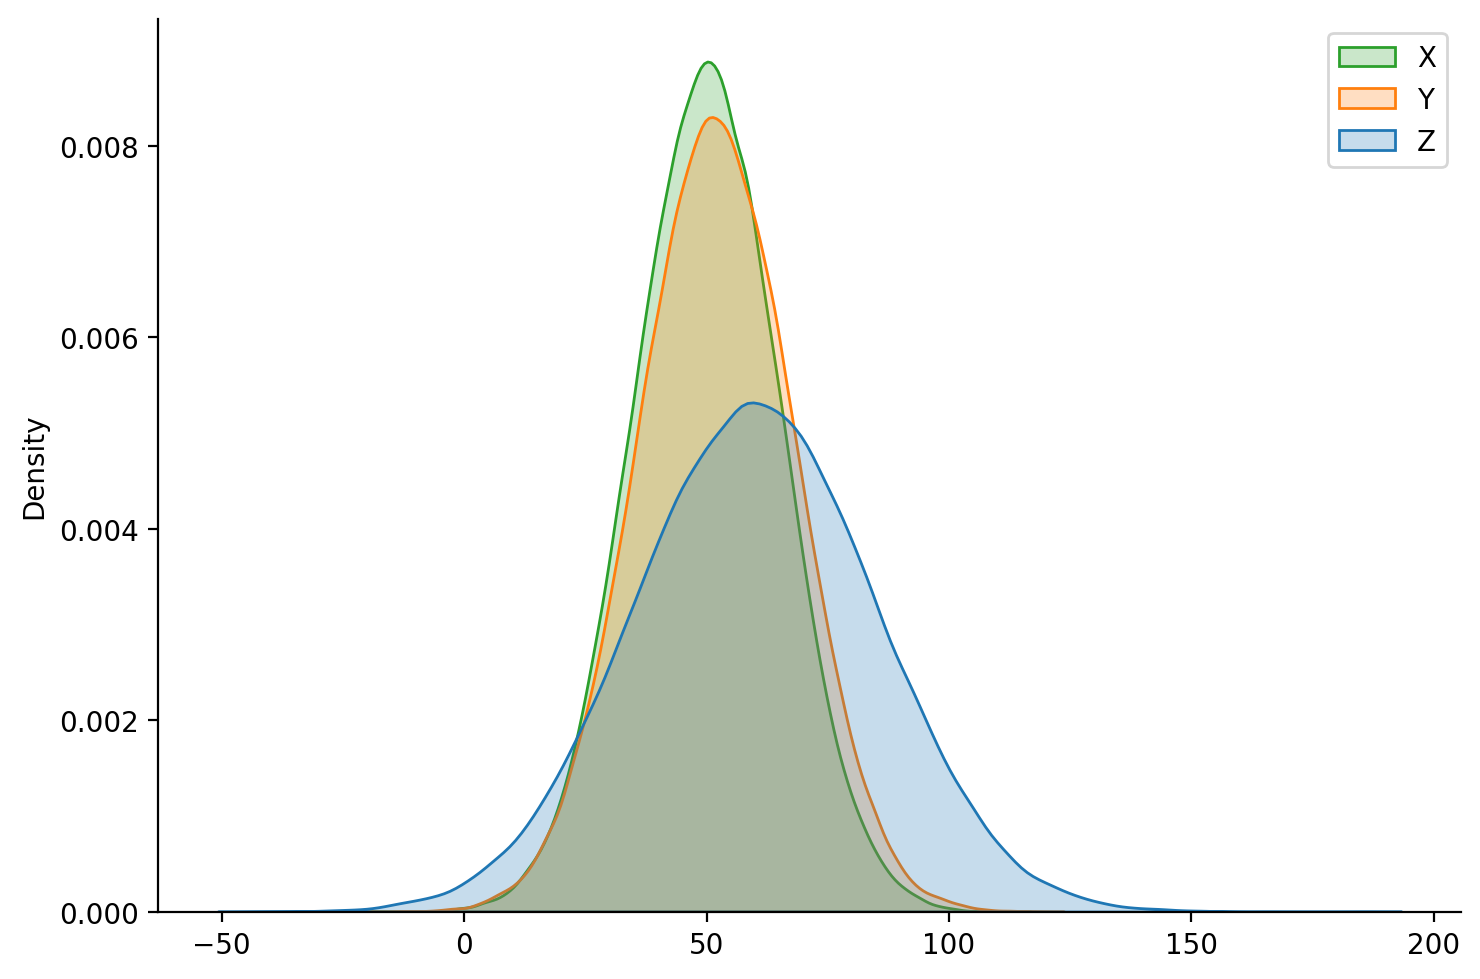

In [10]:
observations = 100000
w = np.random.normal(50, 15, observations) # identical with x
x = np.random.normal(50, 15, observations) # reference
y = np.random.normal(52, 16, observations) # small drift present
z = np.random.normal(60, 25, observations) # major drift 

g = sns.displot(data=[z, y, x], kind='kde', fill=True, legend=False, aspect=1.5)
plt.legend(labels=['X', 'Y', 'Z'])
plt.show()

## Perform KS tests

In [11]:
result = ks_2samp(w, x)
print(f'Comparing distributions w and x (No drift expected)\t=> p_value = {result.pvalue:.4f}, statistic = {result.statistic:.4f}')

result = ks_2samp(x, y)
print(f'Comparing distributions x and y (Small drift expected)\t=> p_value = {result.pvalue:.4f}, statistic = {result.statistic:.4f}')

result = ks_2samp(x, z)
print(f'Comparing distributions x and z (Major drift expected)\t=> p_value = {result.pvalue:.4f}, statistic = {result.statistic:.4f}')

result = ks_2samp(x, 50*z)
print(f'Comparing distributions x and 50*z (Max drift expected)\t=> p_value = {result.pvalue:.4f}, statistic = {result.statistic:.4f}')

Comparing distributions w and x (No drift expected)	=> p_value = 0.6275, statistic = 0.0034
Comparing distributions x and y (Small drift expected)	=> p_value = 0.0000, statistic = 0.0549
Comparing distributions x and z (Major drift expected)	=> p_value = 0.0000, statistic = 0.2628
Comparing distributions x and 50*z (Max drift expected)	=> p_value = 0.0000, statistic = 0.9897


# Chi-squared test
Pearson's chi-squared test is used to determine whether there is a statistically significant difference between the expected frequencies and the observed frequencies in one or more categories of a contingency table.

Practical guidance:

- For categorical columns 
- Chi² statistic as possible indicator for degree of drift: 0 ≤ chisq ≤ ∞
- A typical rule is that all of the reference and current frequencies should be at least 5
- Recommended to compare normalized distributions 
## Create categorical sample data

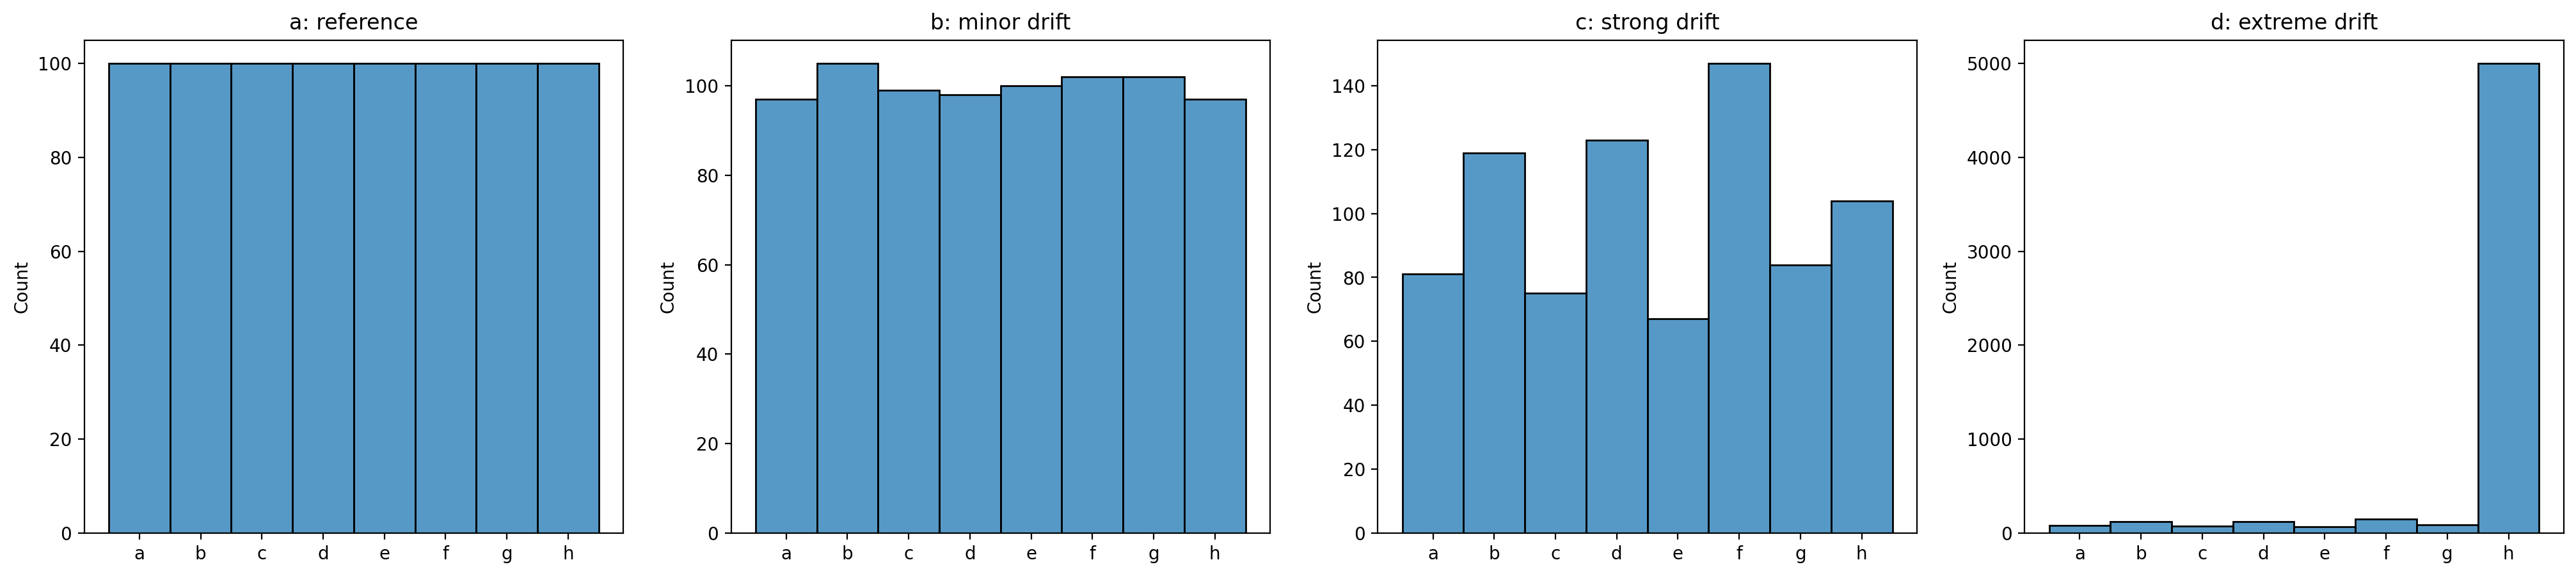

In [12]:
# Sample strings to generate categorical variables: a and b differ slightly. Strong difference between a versus c
a = 100 * 'a' + 100 * 'b' + 100 * 'c' + 100 * 'd' + 100 * 'e' + 100 * 'f' + 100 * 'g' + 100 * 'h'
b = 97 * 'a' + 105 * 'b' + 99 * 'c' + 98 * 'd' + 100 * 'e' + 102 * 'f' + 102 * 'g' + 97 * 'h'
c = 81 * 'a' + 119 * 'b' + 75 * 'c' + 123 * 'd' + 67 * 'e' + 147 * 'f' + 84 * 'g' + 104 * 'h'
d = 81 * 'a' + 119 * 'b' + 75 * 'c' + 123 * 'd' + 67 * 'e' + 147 * 'f' + 84 * 'g' + 5000 * 'h'

# convert to lists
a_list = [letter for letter in a]
b_list = [letter for letter in b]
c_list = [letter for letter in c]
d_list = [letter for letter in d]

# show histograms
fig, axes = plt.subplots(1, 4, figsize=(25, 5))

#create chart in each subplot
sns.histplot(data=a_list,  ax=axes[0]).set(title='a: reference')
sns.histplot(data=b_list,  ax=axes[1]).set(title='b: minor drift')
sns.histplot(data=c_list,  ax=axes[2]).set(title='c: strong drift')
sns.histplot(data=d_list,  ax=axes[3]).set(title='d: extreme drift')
plt.show()

# shuffle lists
random.shuffle(a_list)
random.shuffle(b_list)
random.shuffle(c_list)
random.shuffle(d_list)

## Chi-squared test on normalized frequencies

In [13]:
def chi_test_norm(current, reference):

    # unique values observed in both samples
    values = set(current + reference)
    
    # calculate frequencies
    current_freqs = np.array([current.count(value) for value in values])
    reference_freqs = np.array([reference.count(value) for value in values])

    # calculate expected frequencies for sample of current length given the reference distribution
    reference_ratios = reference_freqs / np.sum(reference_freqs)
    expected_freqs = reference_ratios * len(current)

    result = chisquare(f_obs = current_freqs, f_exp = expected_freqs)

    return result

result = chi_test_norm(a_list, a_list)
print(f'Comparing distribution a and a (No drift expected)\t=> p_value = {result.pvalue:.4f}, statistic = {result.statistic:.4f}')

result = chi_test_norm(a_list, b_list)
print(f'Comparing distribution a and b (Small drift expected)\t=> p_value = {result.pvalue:.4f}, statistic = {result.statistic:.4f}')

result = chi_test_norm(a_list, c_list)
print(f'Comparing distribution a and c (Strong drift expected)\t=> p_value = {result.pvalue:.4f}, statistic = {result.statistic:.4f}')

result = chi_test_norm(a_list, d_list)
print(f'Comparing distribution a and d (Extreme drift expected)\t=> p_value = {result.pvalue:.4f}, statistic = {result.statistic:.4f}')

Comparing distribution a and a (No drift expected)	=> p_value = 1.0000, statistic = 0.0000
Comparing distribution a and b (Small drift expected)	=> p_value = 0.9992, statistic = 0.5530
Comparing distribution a and c (Strong drift expected)	=> p_value = 0.0000, statistic = 54.6070
Comparing distribution a and d (Extreme drift expected)	=> p_value = 0.0000, statistic = 4614.4262


# Wasserstein Distance
Distance function defined between probability distributions on a given metric space M. if each distribution is viewed as a unit amount of earth (soil) piled on M, the metric is the minimum "cost" of turning one pile into the other, which is assumed to be the amount of earth that needs to be moved times the mean distance it must be moved.
- Numerical columns
- Just distance metric (no statistical test)
- Distance metric is dependent on scale of observations (not normalized)



In [14]:
result = wasserstein_distance(w, x)
print(f'Comparing distribution w and x (No drift expected)\t=> distance = {result:.4f}')

result = wasserstein_distance(x, y)
print(f'Comparing distribution x and y (Small drift expected)\t=> distance = {result:.4f}')

result = wasserstein_distance(x, z)
print(f'Comparing distribution x and z (Major drift expected)\t=> distance = {result:.4f}')

Comparing distribution w and x (No drift expected)	=> distance = 0.0688
Comparing distribution x and y (Small drift expected)	=> distance = 1.9006
Comparing distribution x and z (Major drift expected)	=> distance = 11.6583


In [15]:
# illustrate scale-dependence of distance metric 
observations = 1000000

x = np.random.normal(500, 15, observations)
y = np.random.normal(500, 15, observations)
z = np.random.normal(550, 15, observations)

print(wasserstein_distance(x, y))
print(wasserstein_distance(x, z))

0.03364248650239297
50.0305483975498


# Jensen–Shannon distance
The Jenson-Shannon divergence is a method of measuring the similarity between two probability distributions. It is based on the Kullback–Leibler divergence, with some notable and useful differences, including that it is symmetric, and it always has a finite value.
The square root of the Jensen–Shannon divergence is a metric often referred to as __Jensen–Shannon distance__.

- Categorical (or binned numerical) columns 
- Use on observation frequencies or probabilities
- Just distance metric (no statistical test)
- Sample size does not need to be identical


In [16]:
def js_div(current, reference):
    
    values = set(current + reference)
        
    current_freqs = np.array([current.count(value) for value in values])
    reference_freqs = np.array([reference.count(value) for value in values])
    
    current_ratios = current_freqs / np.sum(current_freqs)
    reference_ratios = reference_freqs / np.sum(reference_freqs)

    result = distance.jensenshannon(current_ratios, reference_ratios)
    return result

result = js_div(a_list, a_list)
print(f'Comparing distribution a and a (No drift expected)\t=> distance = {result:.4f}')

result = js_div(a_list, b_list)
print(f'Comparing distribution a and b (Small drift expected)\t=> distance = {result:.4f}')

result = js_div(a_list, c_list)
print(f'Comparing distribution a and c (Major drift expected)\t=> distance = {result:.4f}')

result = js_div(a_list, d_list)
print(f'Comparing distribution a and d (Extreme drift expected)\t=> distance = {result:.4f}')

Comparing distribution a and a (No drift expected)	=> distance = 0.0000
Comparing distribution a and b (Small drift expected)	=> distance = 0.0093
Comparing distribution a and c (Major drift expected)	=> distance = 0.0912
Comparing distribution a and d (Extreme drift expected)	=> distance = 0.5667
